## Post_Analysis2

In [2]:
import os
import numpy as np
import HydroErr as he
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('/Users/dlee/gdrive/gpower/data/dfFlowDams.hdf')
ind_dams = np.load('/Users/dlee/gdrive/gpower/data/ind_dams.npz')['ind_dams']
damList = ind_dams[0,:]
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process...
dorx = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
dorx_ind = np.isin(damList, dorx.values)
# Select dams with DOR threshold
damList = damList[dorx_ind]
ndam = len(damList)

# Load variables
# Number of predicted months per each climate predictor 
NumMonCorr = pd.read_hdf('./data/NumMonCorr.hdf','df')
NumMonCorr = NumMonCorr.loc[damList].reset_index()

# Number of predicted months and KGE at each dam
subset = pd.read_hdf('./data/subset.hdf', 'df')
subset['NMON_MP13'] =  subset['NMON_MP3'] - subset['NMON_MP1']
subset['NMON_MP15'] = subset['NMON_MP5'] - subset['NMON_MP1']
subset['KGE_MP13'] = subset['KGE_MP3'] - subset['KGE_MP1']
subset['KGE_MP15'] = subset['KGE_MP5'] - subset['KGE_MP1']
subset = subset.loc[damList]
subset.head()

,NMON_MP1,NMON_MP2,NMON_MP3,NMON_MP4,NMON_MP5,KGE_MP1,KGE_MP2,KGE_MP3,KGE_MP4,KGE_MP5,NMON_MP13,NMON_MP15,KGE_MP13,KGE_MP15
GRAND_ID,,,,,,,,,,,,,,
6,10.0,8.0,6.0,7.0,5.0,0.771517,0.740698,0.726874,0.727000,0.724744,-4.0,-5.0,-0.044643,-0.046774
25,9.0,7.0,9.0,8.0,7.0,0.617319,0.564271,0.601437,0.615051,0.601788,0.0,-2.0,-0.015882,-0.015531
27,6.0,3.0,6.0,5.0,5.0,0.609065,0.555172,0.574441,0.580823,0.570962,0.0,-1.0,-0.034624,-0.038103
31,5.0,6.0,7.0,8.0,5.0,0.678594,0.682077,0.686184,0.713809,0.685329,2.0,0.0,0.007590,0.006736
35,6.0,8.0,7.0,6.0,5.0,0.402699,0.405489,0.394405,0.370539,0.369723,1.0,-1.0,-0.008294,-0.032976


### Initialize mapping parameters

In [4]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
from tools import cbarpam, GDFPlotOrder
# Load 1593 GranD dam shapefile
gdfDam = gpd.read_file('./data/granddams_eval.shp')
gdfDam = gdfDam.drop(gdfDam.columns[1:-1], axis=1)
gdfDam = gdfDam.set_index('GRAND_ID').loc[damList].reset_index(drop=False)
# Load world base map (exclude Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
# Reprojection to Robinson projection (ESRI:54030)
lims = [-135, 167, -55, 80]
if True:
    inProj = Proj(init="epsg:4326")
    outProj = Proj(init="esri:54030")
    world = world.to_crs({'init':'esri:54030'})
    gdfDam = gdfDam.to_crs({'init':'esri:54030'})
    xmin, _ = transform(inProj, outProj, lims[0], 0)
    xmax, _ = transform(inProj, outProj, lims[1], 0)
    _, ymin = transform(inProj, outProj, 0, lims[2])
    _, ymax = transform(inProj, outProj, 0, lims[3])
lims = [xmin, xmax, ymin, ymax]        

### (a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)

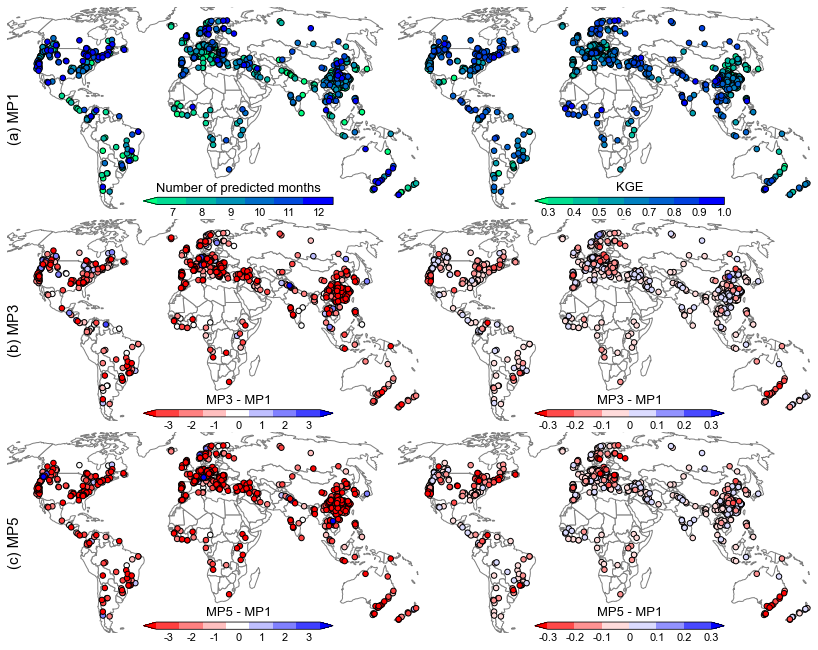

./figures/dam_pmonth_wkge.pdf is saved.


In [5]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')

# Colormaps
# (1) Number of predicted months of MP1
bounds1 = list(np.arange(6.5,13.5,1))
boundaries1 = [0] + bounds1
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'winter_r', labloc='in',
                                                          boundaries=boundaries1, extension='min')
# (2) Difference of number of predicted months from MP1
bounds2 = list(np.arange(-3.5,4.5,1))
boundaries2 = [-10]+bounds2+[10]
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'bwr_r', labloc='in',
                                                          boundaries=boundaries2, extension='both')
# (3) KGE of MP1
bounds3 = list(np.arange(0.3,1.1,0.1))
boundaries3 = [-1]+bounds3
cmap3, norm3, vmin3, vmax3, ticks3, boundaries3 = cbarpam(bounds3, 'winter_r', labloc='on',
                                                          boundaries=boundaries3, extension='min')
# (4) Difference of KGE from MP1
bounds4 = list(np.arange(-0.3,0.4,0.1))
boundaries4 = [-1]+bounds4+[1]
cmap4, norm4, vmin4, vmax4, ticks4, boundaries4 = cbarpam(bounds4, 'bwr_r', labloc='on',
                                                          boundaries=boundaries4, extension='both')

# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['(a) MP1','(b) MP3','(c) MP5']
colList = ['NMON_MP1','NMON_MP13','NMON_MP15','KGE_MP1','KGE_MP13','KGE_MP15']
for (i, el) in enumerate(colList):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    if i == 0:
        GDFPlotOrder(damMap, boundaries1, ax, el, 
                     cmap1, norm1, vmin1, vmax1, order='seq')
    elif i == 1 or i == 2:        
        GDFPlotOrder(damMap, boundaries2, ax, el, 
                     cmap2, norm2, vmin=vmin2, vmax=vmax2, order='div')
    elif i == 3:
        GDFPlotOrder(damMap, boundaries3, ax, el, 
                     cmap3, norm3, vmin=vmin3, vmax=vmax3, order='seq')  
    else:
        GDFPlotOrder(damMap, boundaries4, ax, el, 
                     cmap4, norm4, vmin=vmin4, vmax=vmax4, order='div')
    if i < 3:
        ax.annotate(figLabel[i], xy=(0.02, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15,rotation=90)
plt.tight_layout(w_pad=-5)
# Colorbars
for i in range(6):
    ax = axes.flatten('F')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    if i == 0:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks1]
        clabel = 'Number of predicted months'
    elif i == 1 or i==2:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks2]
        if i == 1:
            clabel = 'MP3 - MP1'
        else:
            clabel = 'MP5 - MP1'
    elif i == 3:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3,
                                         boundaries=boundaries3,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks3,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks3]
        tlabel[0] = '0.3'; #tlabel = np.array(tlabel); tlabel[1::2] = ''
        clabel = 'KGE'
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap4, norm=norm4,
                                         boundaries=boundaries4,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks4,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks4]
        tlabel[3] = '0'
        if i == 4:
            clabel = 'MP3 - MP1'
        else:
            clabel = 'MP5 - MP1'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if True:
    fn_save = './figures/dam_pmonth_wkge.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (b) Number of months correlated with predictor (MP1)

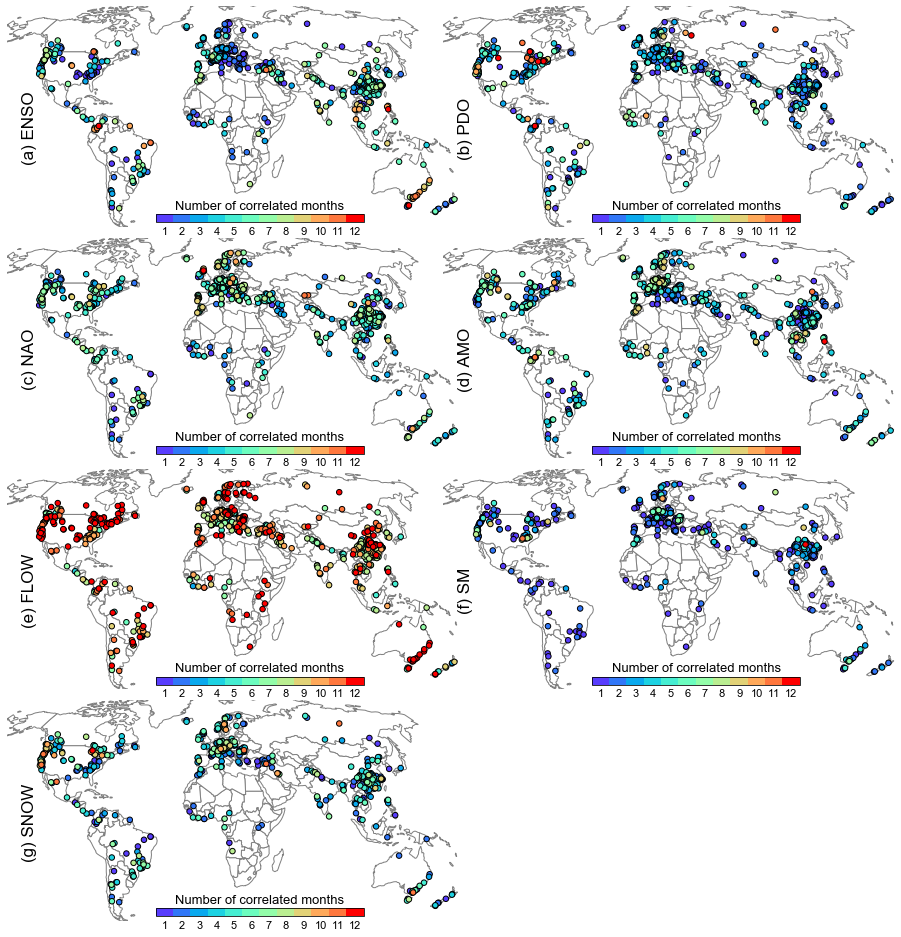

./figures/nmon_correlated.pdf is saved.


In [6]:
# (a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(NumMonCorr, on='GRAND_ID')

# Colormaps
# (1) Number of correlated months of MP1
bounds = list(np.arange(0.5,13.5,1))
boundaries = bounds
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'rainbow', labloc='in',
                                                    boundaries=boundaries, extension='min')

# Plotting
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,13), facecolor='w')
figLabel = ['(a) ENSO','(b) PDO','(c) NAO','(d) AMO','(e) FLOW','(f) SM', '(g) SNOW']
colList = ['ENSO','PDO','NAO','AMO','FLOW','SM','SNOW']
for (i, el) in enumerate(colList):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    GDFPlotOrder(damMap, boundaries, ax, el, cmap, norm, vmin, vmax, order='seq')
    ax.annotate(figLabel[i], xy=(0.05, 0.45), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=17,rotation=90,backgroundcolor='w')

ax = axes.flatten('F')[7]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
    
plt.tight_layout(w_pad=-12)
# Colorbars
for i in range(7):
    ax = axes.flatten('C')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                     boundaries=boundaries,
                                     ticks = ticks,
                                     spacing='uniform',
                                     orientation='horizontal')
    tlabel = ['%d'%lb for lb in ticks]
    clabel = 'Number of correlated months'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if True:
    fn_save = './figures/nmon_correlated.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)